In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan

In [33]:
# read the dataset
country_df = pd.read_csv("Country-data.csv", sep=",")
country_df.head()


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


In [34]:
# Lets check for null values
country_df.info()
# All colums are non-null no need for imputing the missing values
country_df.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
country       167 non-null object
child_mort    167 non-null float64
exports       167 non-null float64
health        167 non-null float64
imports       167 non-null float64
income        167 non-null int64
inflation     167 non-null float64
life_expec    167 non-null float64
total_fer     167 non-null float64
gdpp          167 non-null int64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.1+ KB


(167, 10)

In [35]:
#Converting exports,imports and health spending percentages to absolute values.
country_df['exports'] = country_df['exports']*country_df['gdpp']/100
country_df['imports'] = country_df['imports']*country_df['gdpp']/100
country_df['health'] = country_df['health']*country_df['gdpp']/100



#Lets see the data distribution 
country_df.describe()

#Seems from the data the gap between 75% and max is lot

,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000
mean,38.270060,7420.618847,1056.733204,6588.352108,17144.688623,7.781832,70.555689,2.947964,12964.155689
std,40.328931,17973.885795,1801.408906,14710.810418,19278.067698,10.570704,8.893172,1.513848,18328.704809
min,2.600000,1.076920,12.821200,0.651092,609.000000,-4.210000,32.100000,1.150000,231.000000
25%,8.250000,447.140000,78.535500,640.215000,3355.000000,1.810000,65.300000,1.795000,1330.000000
50%,19.300000,1777.440000,321.886000,2045.580000,9960.000000,5.390000,73.100000,2.410000,4660.000000
75%,62.100000,7278.000000,976.940000,7719.600000,22800.000000,10.750000,76.800000,3.880000,14050.000000
max,208.000000,183750.000000,8663.600000,149100.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000


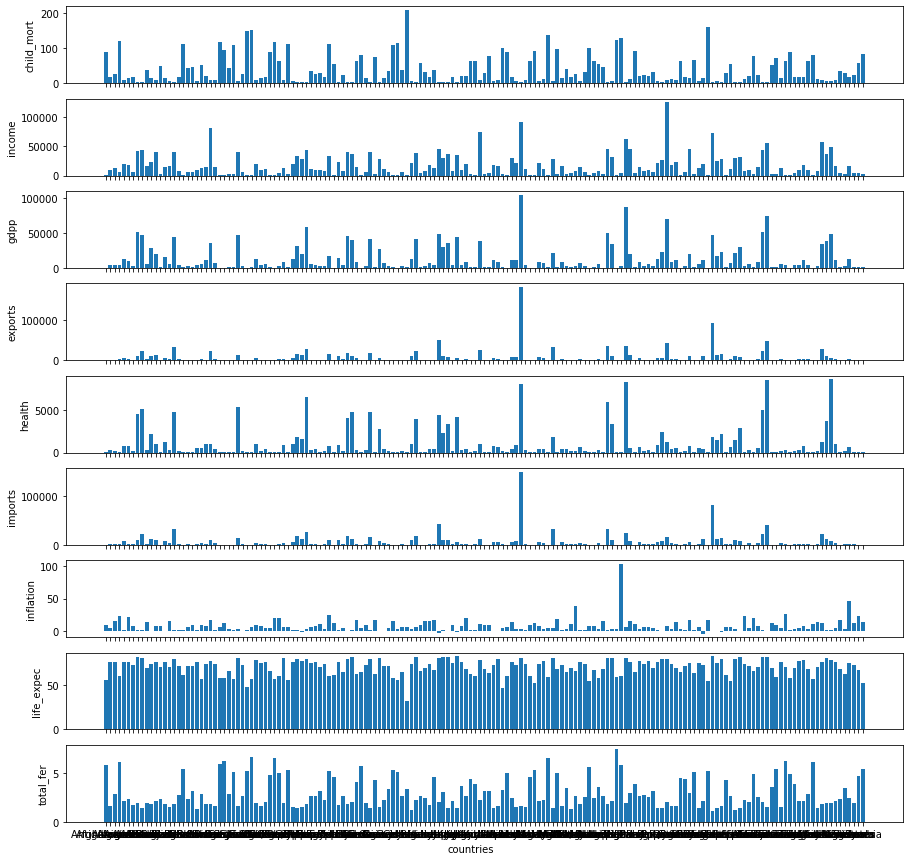

In [36]:
## Lets perform some visualisation 
num_cols_for_cluster=['child_mort','income','gdpp','exports','health','imports', 'inflation', 'life_expec', 'total_fer'] 
fig,axs = plt.subplots(len(num_cols_for_cluster), sharex=True, figsize=(15,15))
fig.text(0.5, 0.1, 'countries', ha='center', va='center')    
for i in list(enumerate(num_cols_for_cluster)):
    axs[i[0]].bar(country_df['country'], country_df[num_cols_for_cluster[i[0]]])
    plt.setp(axs[i[0]], ylabel=num_cols_for_cluster[i[0]])
plt.show()

#If we visualize the the bars height we observe that 
#       we can form groups of bars which are at approx same heights.
#       We can also see some outliers like some bars are going too high

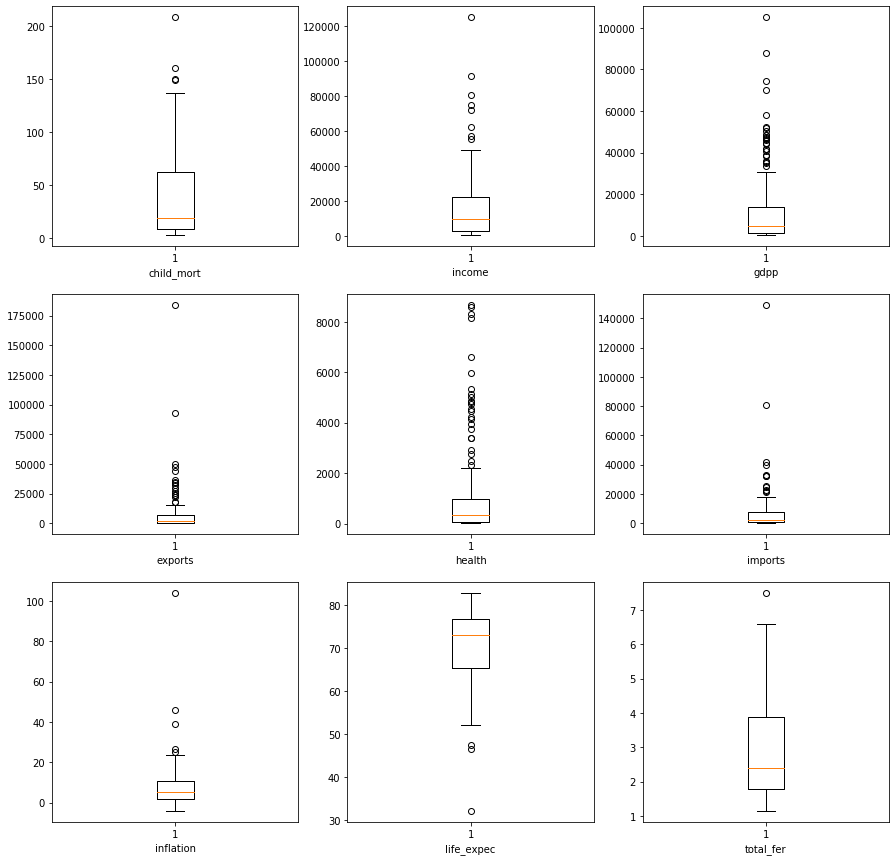

In [37]:
#Lets visualize the boxplots to check for outliers

fig,axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i, ax in enumerate(axs.flat):
    ax.boxplot(country_df[num_cols_for_cluster[i]])
    plt.setp(ax, xlabel=num_cols_for_cluster[i])

plt.show()
# from the plot it is confirmed that we have outliers

In [38]:
# Copy the data frame for rest of the processing
country_scale_outlrtrt_df = country_df.copy(deep=True)

#Lets perform capping of data for outlier treatment
outlier_high_dict = {}
outlier_high_dict['child_mort'] = 0.8
outlier_high_dict['income'] = 0.95
outlier_high_dict['gdpp'] = 0.85
outlier_high_dict['exports'] = 0.85
outlier_high_dict['health'] = 0.85
outlier_high_dict['imports'] = 0.90
outlier_high_dict['inflation'] = 0.90
outlier_high_dict['total_fer'] = 0.99

outlier_low_dict = {}
outlier_low_dict['life_expec'] = 0.5

for k,v in outlier_high_dict.items():
    t = country_scale_outlrtrt_df[k].quantile(v)
    country_scale_outlrtrt_df[k].clip(upper=t,inplace=True)
    
t=country_scale_outlrtrt_df['life_expec'].quantile(0.2)    
country_scale_outlrtrt_df['life_expec'].clip(lower=t,inplace=True)

In [39]:
from sklearn.preprocessing import MinMaxScaler

In [40]:
#Lets perform scaling
scaler = MinMaxScaler()
country_scale_outlrtrt_df[num_cols_for_cluster] = scaler.fit_transform(country_scale_outlrtrt_df[num_cols_for_cluster])



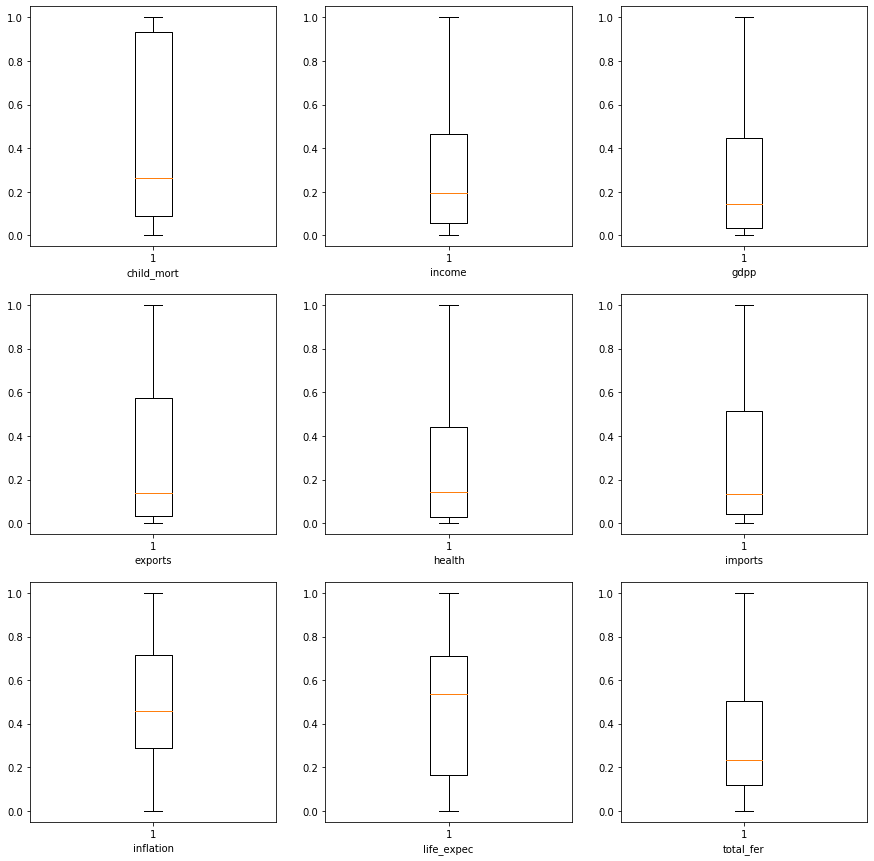

In [41]:
# Lets check the data distribution after Scaling and outliers treatment using boxplots
fig,axs = plt.subplots(ncols=3, nrows=3, figsize=(15,15))

for i, ax in enumerate(axs.flat):
    ax.boxplot(country_scale_outlrtrt_df[num_cols_for_cluster[i]])
    plt.setp(ax, xlabel=num_cols_for_cluster[i])

plt.show()

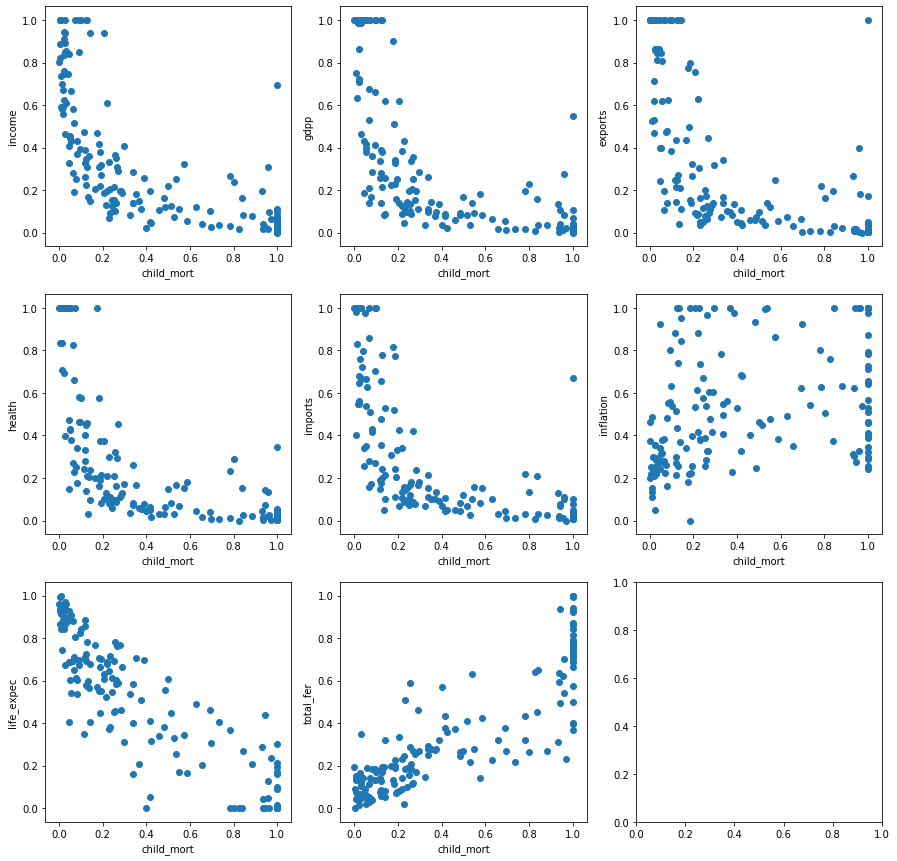

In [42]:
#Lets visualize using scatter plots
num_cols_for_plot=['income','gdpp','exports','health','imports', 'inflation', 'life_expec', 'total_fer']

fig, axs = plt.subplots(3,3,figsize=(15,15))
for i, ax in enumerate(axs.flat):
     if i < len(num_cols_for_plot):
         ax.scatter(x=country_scale_outlrtrt_df['child_mort'], y=country_scale_outlrtrt_df[num_cols_for_plot[i]])
         ax.set_ylabel(num_cols_for_plot[i])
         ax.set_xlabel('child_mort')  

plt.show()

In [43]:
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) # heuristic from article [1]
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        H = 0
 
    return H

In [44]:
# The Hopkins score varies from 0.79 t0 .85 (if we run Hopkins on the dataset for 5 tries), 
# Since it has value >0.7 so the data has clustering tendency
hopkins(country_scale_outlrtrt_df[num_cols_for_cluster])

0.790220111129772

<function matplotlib.pyplot.show(*args, **kw)>

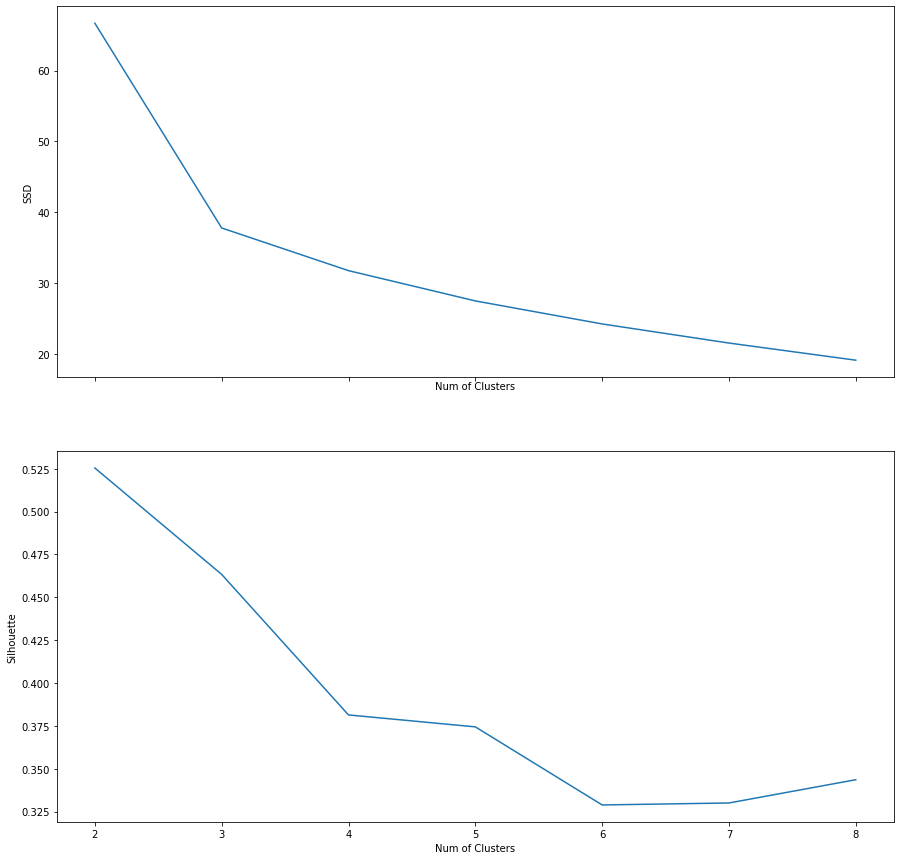

In [45]:
# To find the number of clusters plot 2 graphs

#        1.  elbow-curve/SSD
#        2.  silhouette curve
ssd = []
silhouette = []
range_trial= [2, 3, 4, 5, 6, 7, 8]
for num in range_trial:
    kmeans = KMeans(n_clusters=num)
    kmeans.fit(country_scale_outlrtrt_df[num_cols_for_cluster])
    ssd.append(kmeans.inertia_)
    clustr_lbl = kmeans.labels_
    silhouette_avg = silhouette_score(country_scale_outlrtrt_df[num_cols_for_cluster], clustr_lbl)
    silhouette.append(silhouette_avg)

fig,axs = plt.subplots(2, sharex=True, figsize=(15,15))
axs[0].plot(ssd) 
axs[1].plot(silhouette)
plt.setp(axs, xlabel="Num of Clusters")
plt.xticks(range(len(range_trial)), range_trial)
plt.setp(axs[0], ylabel="SSD")
plt.setp(axs[1], ylabel="Silhouette")
plt.show    


In [46]:
# From both curves number of cluster = 3 seems to be optimal
# Creating final model with 3
# final model with k=3, Keeping default iteration =300
kmeans = KMeans(n_clusters=3)
kmeans.fit(country_scale_outlrtrt_df[num_cols_for_cluster])
country_scale_outlrtrt_df['kmeans_id']=kmeans.labels_
country_scale_outlrtrt_df.kmeans_id.value_counts()

#The distribution with 3 cluster looks balanced i.e non of the cluster has few .

2    68
0    58
1    41
Name: kmeans_id, dtype: int64

##Final visualisation using child mortality, income and gdpp

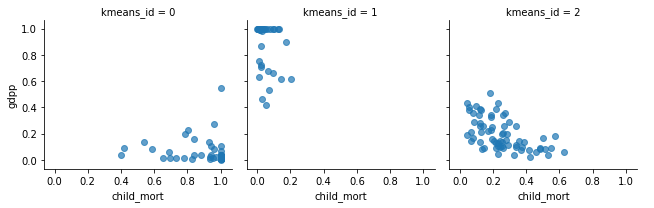

In [47]:
g = sns.FacetGrid(country_scale_outlrtrt_df, col="kmeans_id")
g.map(plt.scatter,'child_mort', 'gdpp', alpha=.7)
g.add_legend()

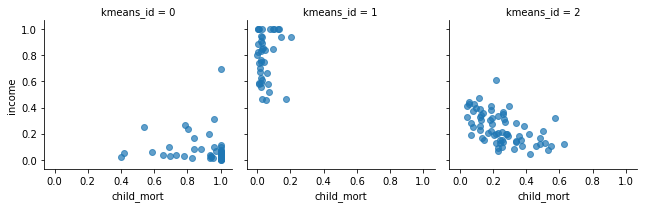

In [48]:
g1 = sns.FacetGrid(country_scale_outlrtrt_df, col="kmeans_id")
g1.map(plt.scatter,'child_mort', 'income', alpha=.7)
g1.add_legend()

In [49]:
# Seems Like Cluter id 0 is the cluster with high cild mortality, low income and low gdpp.

country_df['Kmeans_ID'] = kmeans.labels_

Country_kmeans_needs_help = country_df[country_df['Kmeans_ID']==0]
print(Country_kmeans_needs_help.shape)
Country_kmeans_needs_help.head()

(58, 11)


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Kmeans_ID
0,Afghanistan,90.2,55.300,41.9174,248.297,1610,9.440,56.2,5.82,553,0
3,Angola,119.0,2199.190,100.6050,1514.370,5900,22.400,60.1,6.16,3530,0
12,Bangladesh,49.4,121.280,26.6816,165.244,2440,7.140,70.4,2.33,758,0
17,Benin,111.0,180.404,31.0780,281.976,1820,0.885,61.8,5.36,758,0
19,Bolivia,46.6,815.760,95.8320,679.140,5410,8.780,71.6,3.20,1980,0


In [50]:
Country_kmeans_needs_help.sort_values(by=['income', 'gdpp'], ascending=True, inplace=True)


C:\Users\shobh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [51]:
Country_kmeans_needs_help

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Kmeans_ID
37,"Congo, Dem. Rep.",116.0,137.27400,26.4194,165.664000,609,20.800,57.5,6.54,334,0
88,Liberia,89.3,62.45700,38.5860,302.802000,700,5.470,60.8,5.02,327,0
26,Burundi,93.6,20.60520,26.7960,90.552000,764,12.300,57.7,6.26,231,0
112,Niger,123.0,77.25600,17.9568,170.868000,814,2.550,58.8,7.49,348,0
31,Central African Republic,149.0,52.62800,17.7508,118.190000,888,2.010,47.5,5.21,446,0
106,Mozambique,101.0,131.98500,21.8299,193.578000,918,7.640,54.5,5.56,419,0
94,Malawi,90.5,104.65200,30.2481,160.191000,1030,12.100,53.1,5.31,459,0
63,Guinea,109.0,196.34400,31.9464,279.936000,1190,16.100,58.0,5.34,648,0
150,Togo,90.3,196.17600,37.3320,279.624000,1210,1.180,58.7,4.87,488,0
132,Sierra Leone,160.0,67.03200,52.2690,137.655000,1220,17.200,55.0,5.20,399,0


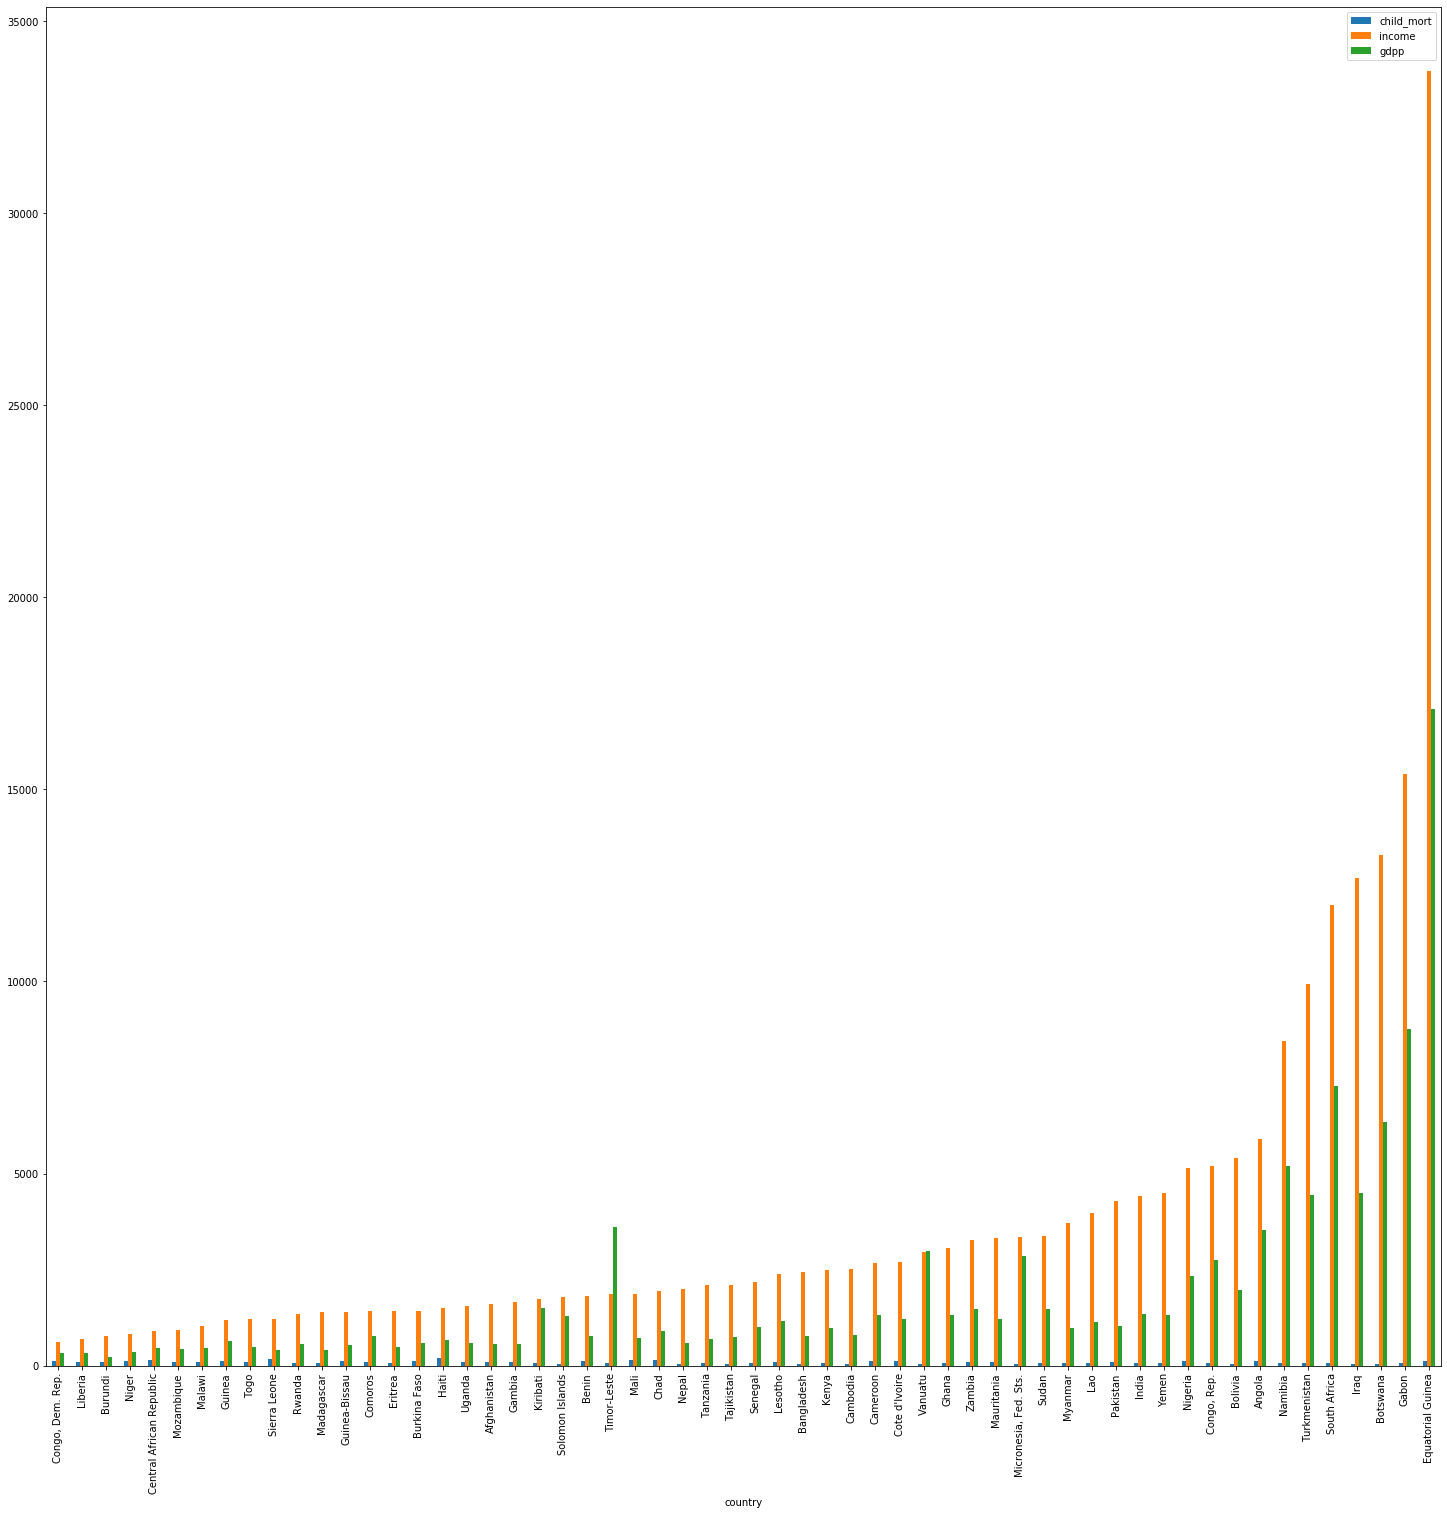

In [52]:
Country_kmeans_needs_help.plot.bar(x='country', y=['child_mort','income','gdpp'], rot=90, figsize=(25,25))
Country_kmeans_needs_help_scaled=country_scale_outlrtrt_df[country_scale_outlrtrt_df['kmeans_id']==0]

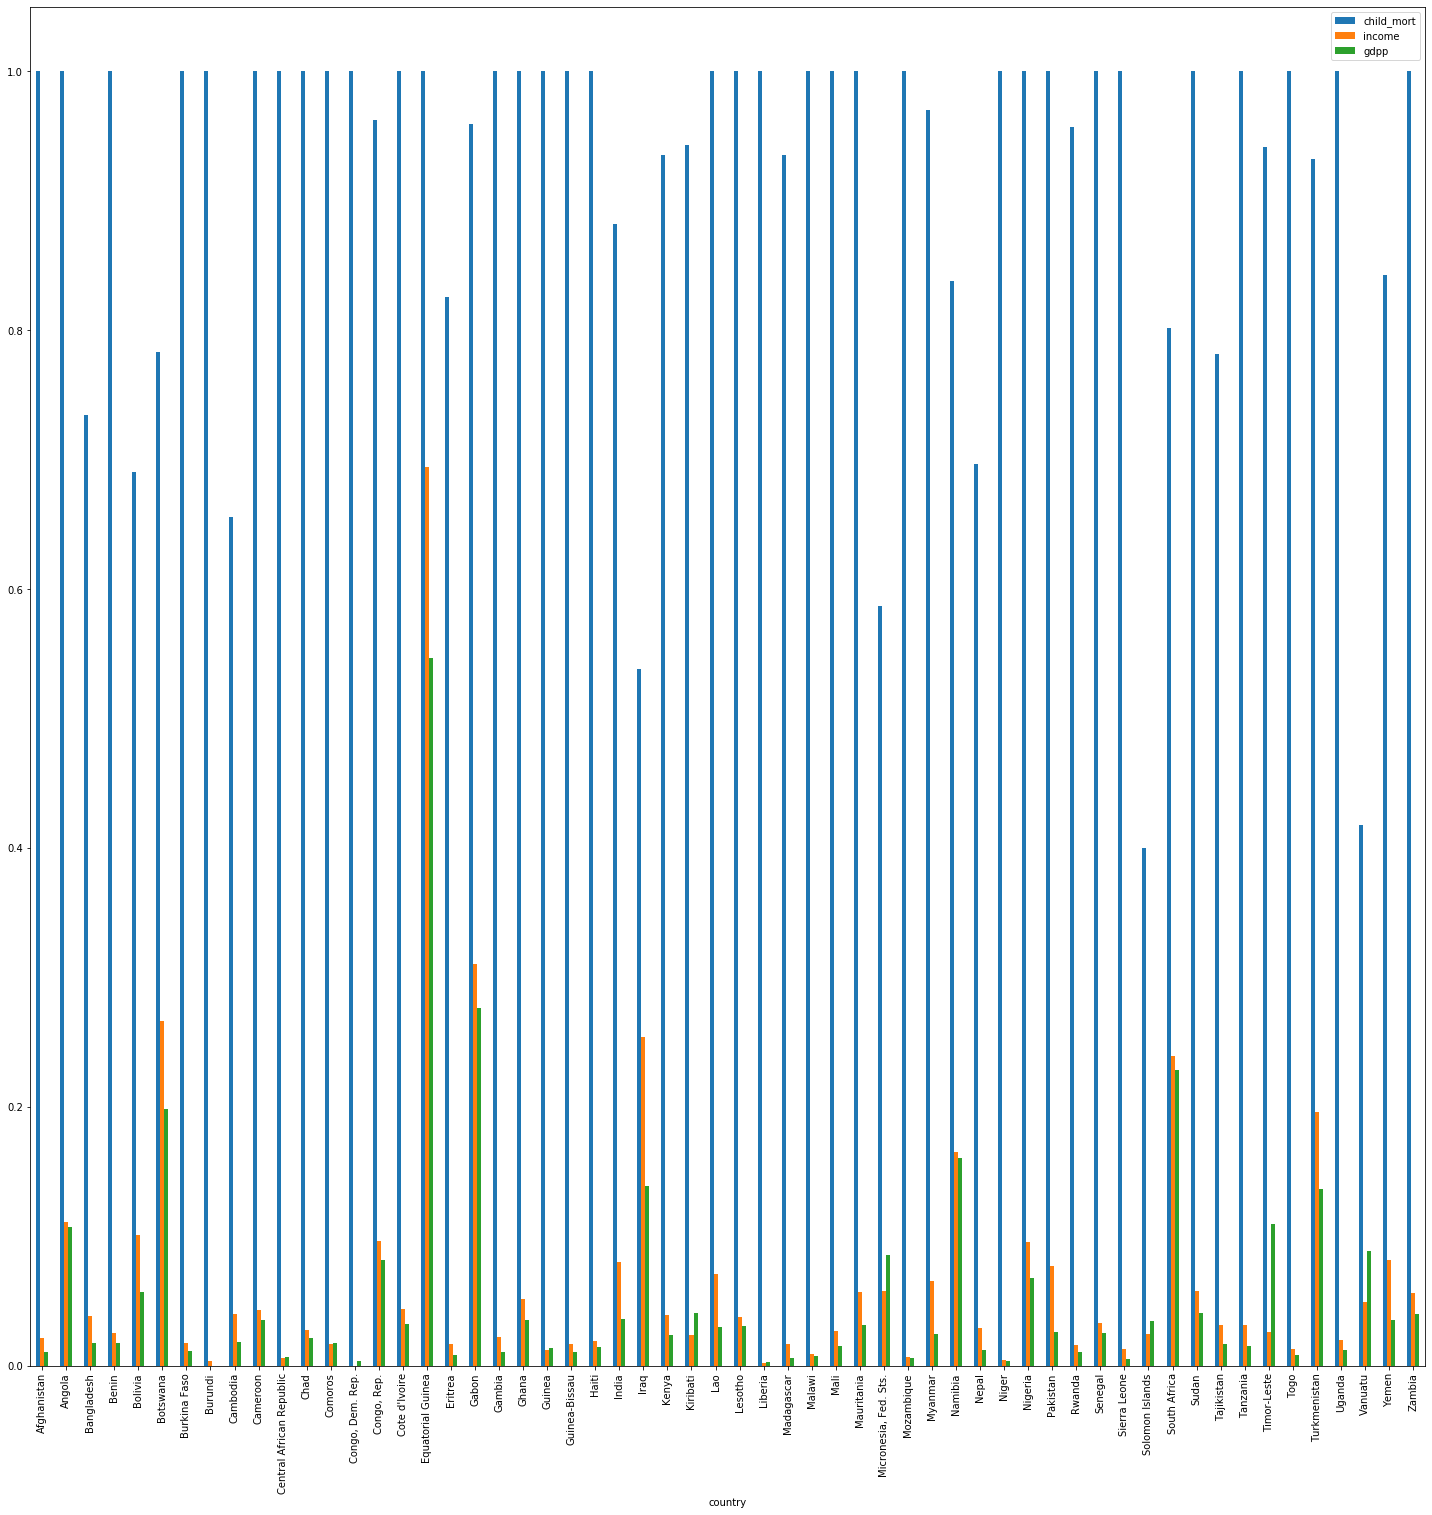

In [53]:
Country_kmeans_needs_help_scaled.plot.bar(x='country', y=['child_mort','income','gdpp'], rot=90, figsize=(25,25))

### so from Kmeans clustering and above visulisation the 5 countries who need help in cluster with high child_mortality cluster are the countries with low income and gdpp
1. Kyrgyz Republic
2. Moldova
3. Uzbekistan
4. Vietnam 
5. Tonga


#Hierarchical Clustering

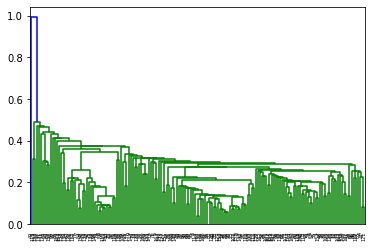

In [54]:
mergings = linkage(country_scale_outlrtrt_df[num_cols_for_cluster], method="single", metric='euclidean')
dendrogram(mergings)
plt.show()

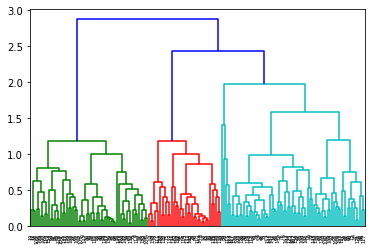

In [55]:
mergings = linkage(country_scale_outlrtrt_df[num_cols_for_cluster], method="complete", metric='euclidean')
dendrogram(mergings)
plt.show()

In [56]:
#So from above 2 dendograms the Hierarchical clustering with complete linkage has better trees and clear that we have 3 clusters
# Lets use Hierarchical cluster with complete linkage to make clustrers
Hier_labels = cut_tree(mergings, n_clusters=3).reshape(-1, )
Hier_labels



array([0, 1, 1, 0, 1, 1, 1, 2, 2, 1, 2, 2, 0, 1, 1, 2, 1, 0, 0, 0, 1, 0,
       1, 1, 1, 0, 0, 0, 0, 2, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 2, 2,
       2, 1, 1, 1, 1, 1, 0, 1, 0, 2, 2, 0, 0, 1, 2, 0, 2, 1, 1, 0, 0, 0,
       0, 1, 2, 0, 1, 1, 1, 2, 2, 2, 1, 2, 1, 1, 0, 0, 2, 1, 0, 1, 1, 0,
       0, 1, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0,
       2, 2, 0, 0, 2, 1, 0, 1, 1, 1, 1, 1, 2, 2, 1, 1, 0, 1, 1, 0, 1, 1,
       0, 2, 2, 2, 0, 0, 2, 2, 1, 1, 0, 1, 2, 2, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 1, 2, 2, 2, 1, 1, 0, 1, 1, 0, 0])

In [57]:
# Checking the distribution in each cluster. It looks OK
country_scale_outlrtrt_df['hier_labels']=Hier_labels
country_scale_outlrtrt_df['hier_labels'].value_counts()

1    72
0    59
2    36
Name: hier_labels, dtype: int64

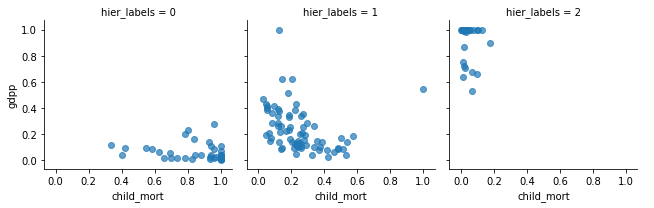

In [58]:
g2 = sns.FacetGrid(country_scale_outlrtrt_df, col="hier_labels")
g2.map(plt.scatter,'child_mort', 'gdpp', alpha=.7)
g2.add_legend()

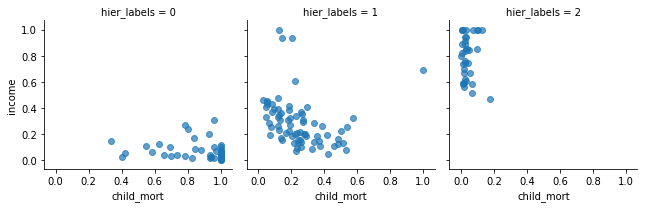

In [59]:
g3 = sns.FacetGrid(country_scale_outlrtrt_df, col="hier_labels")
g3.map(plt.scatter,'child_mort', 'income', alpha=.7)
g3.add_legend()

In [60]:
# So label = 0, has high child mort, low income and low gdpp
country_df['Hier_ID'] = Hier_labels
Country_HierClus_needs_help = country_df[country_df['Hier_ID']==0]
print(Country_HierClus_needs_help.shape)

(59, 12)


In [61]:
Country_HierClus_needs_help.sort_values(by=['income', 'gdpp'], ascending=True, inplace=True)

Country_HierClus_needs_help.head()

C:\Users\shobh\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp,Kmeans_ID,Hier_ID
37,"Congo, Dem. Rep.",116.0,137.2740,26.4194,165.664,609,20.80,57.5,6.54,334,0,0
88,Liberia,89.3,62.4570,38.5860,302.802,700,5.47,60.8,5.02,327,0,0
26,Burundi,93.6,20.6052,26.7960,90.552,764,12.30,57.7,6.26,231,0,0
112,Niger,123.0,77.2560,17.9568,170.868,814,2.55,58.8,7.49,348,0,0
31,Central African Republic,149.0,52.6280,17.7508,118.190,888,2.01,47.5,5.21,446,0,0


C:\Users\shobh\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


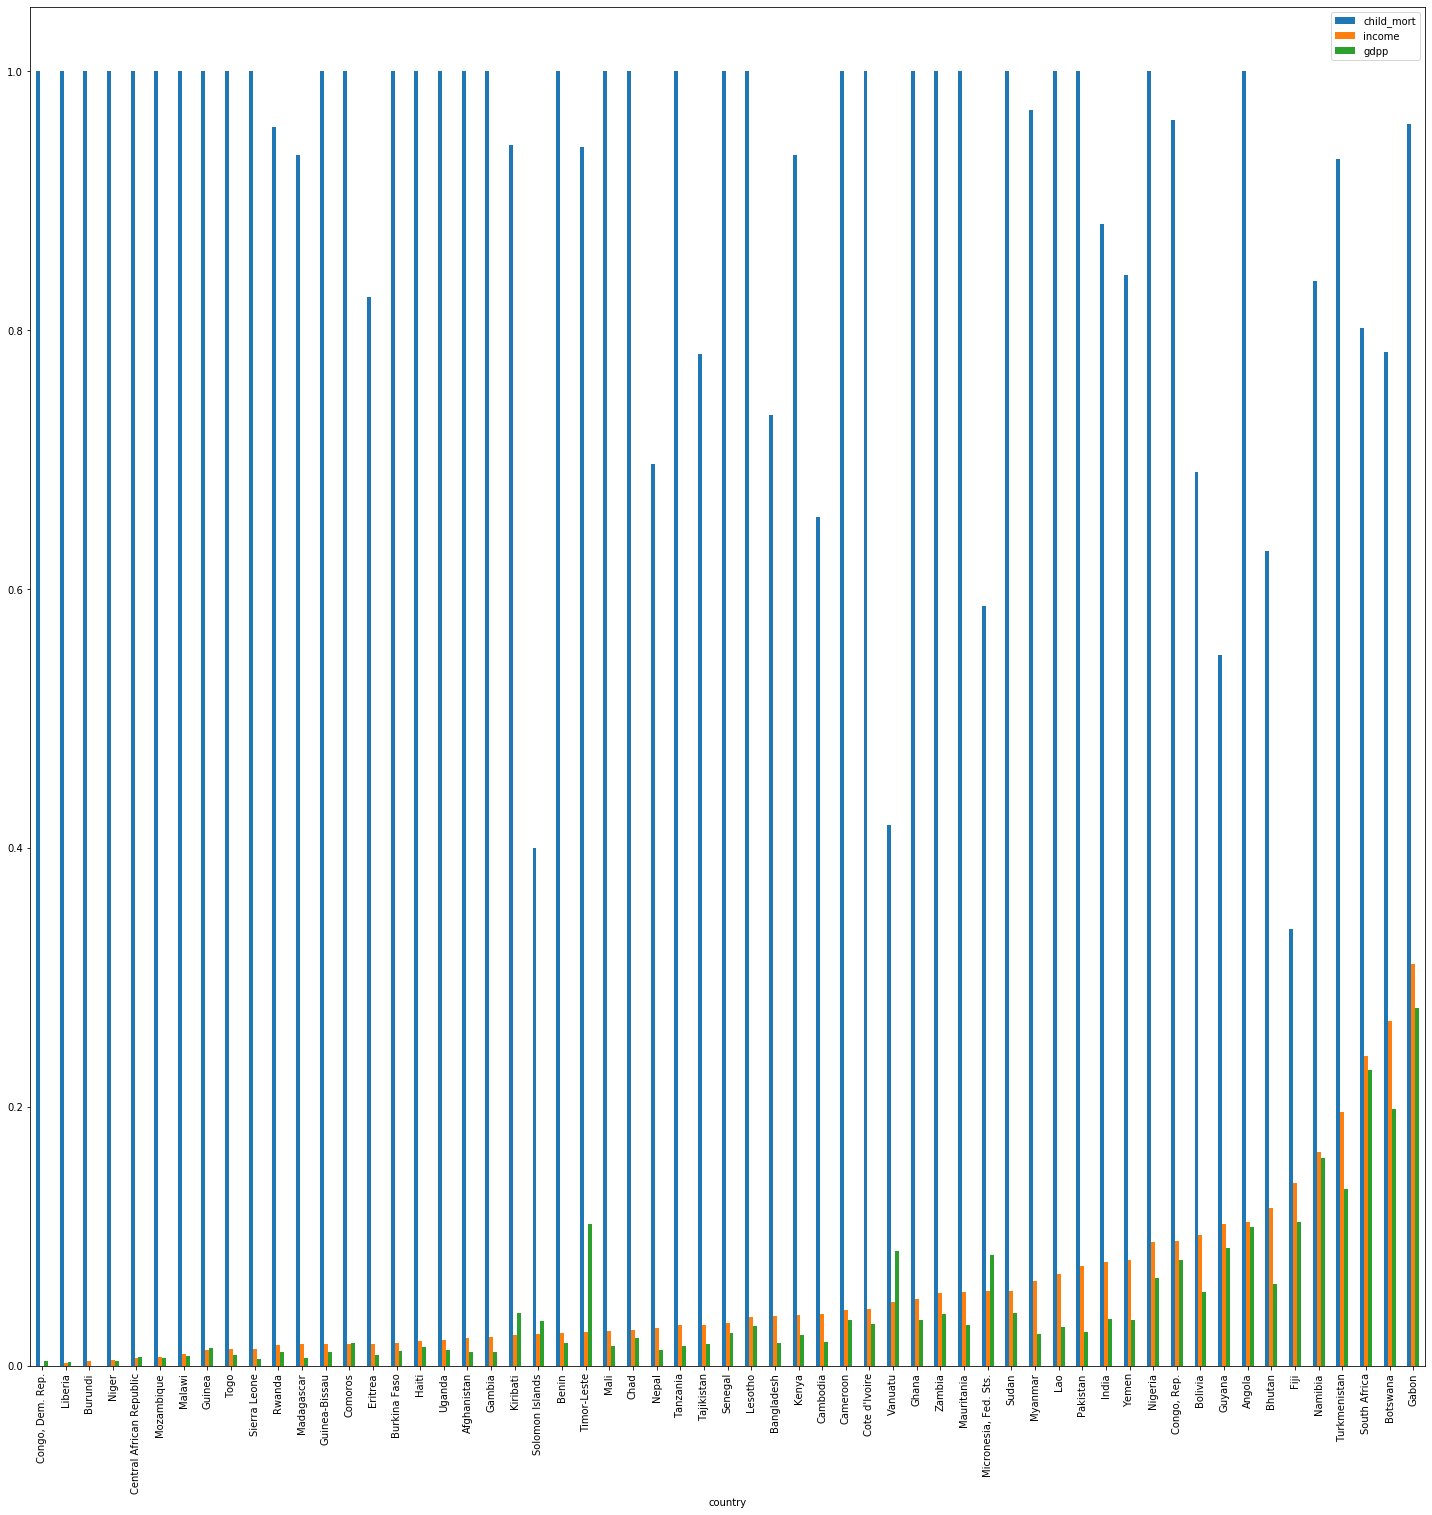

In [62]:
Country_hier_needs_help_scaled = country_scale_outlrtrt_df[country_scale_outlrtrt_df['hier_labels']==0]
Country_hier_needs_help_scaled.sort_values(by=['income', 'gdpp'], ascending=True, inplace=True)
Country_hier_needs_help_scaled.plot.bar(x='country', y=['child_mort','income','gdpp'], rot=90, figsize=(25,25))


# Above plot after Hier clustering makes more sense.
# it has highest child_mort and low income and gdpp
So as per this graph and dataframe Country_HierClus_needs_help
1. Congo Dem Rep
2. Liberia
3. Burundi
4. Niger
5. Central african republic
